In [1]:
## Authenticate and mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/X_ray_photos/

/content/drive/My Drive/X_ray_photos


In [3]:
!ls

covid19  foo.png  model.png  normal  test  train  validation


### Importing libraries

In [4]:
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import glob
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
base_dir = !pwd
base_dir = base_dir[0]
print(base_dir)
print(type(base_dir))

/content/drive/My Drive/X_ray_photos
<class 'str'>


In [6]:
# classes = ['covid19', 'normal']

In [7]:
# # The code below creates a train and a val folder each containing 2 folders (one for each type of X_ray image).
# # It then copies the images from the original folders to these new folders such that 75% of the images go
# # to the training set and 25% of the images go into the validation set.

# for i in classes:

#   os.makedirs(base_dir +'/train/' + i)
#   os.makedirs(base_dir +'/validation/' + i)
#   source = base_dir + '/' + i
#   allFileNames = os.listdir(source)
#   np.random.shuffle(allFileNames)
#   test_ratio = 0.25

#   train_FileNames, test_FileNames = np.split(np.array(allFileNames),
#                                                       [int(len(allFileNames)* (1 - test_ratio))])

#   train_FileNames = [source+'/'+ name for name in train_FileNames.tolist()]
#   test_FileNames = [source+'/' + name for name in test_FileNames.tolist()]

#   for name in train_FileNames:
#     shutil.copy(name, base_dir +'/train/' + i)

#   for name in test_FileNames:
#     shutil.copy(name, base_dir +'/validation/' + i)

In [8]:
!ls

covid19  foo.png  model.png  normal  test  train  validation


In [9]:
# Setting paths for training an validation sets
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [10]:
print(train_dir)
print(val_dir)
print(test_dir)
print(type(train_dir))

/content/drive/My Drive/X_ray_photos/train
/content/drive/My Drive/X_ray_photos/validation
/content/drive/My Drive/X_ray_photos/test
<class 'str'>


In [109]:
BATCH_SIZE = 20  # Number of training examples to process before updating our models variables
IMG_SHAPE  = 180  # Our training data consists of images with width of 180 pixels and height of 180 pixels

In [110]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
      img = img.reshape((180,180))
      ax.imshow(img, cmap='gray')
    plt.tight_layout()
    plt.show()

In [111]:
# Read images from the disk.
# Decode contents of these images and convert it into proper grid format as per their RGB content.
# Convert them into floating point tensors.
# Rescale the tensors from values between 0 and 255 to values between 0 and 1, 
# as neural networks prefer to deal with small input values.
image_gen_train = ImageDataGenerator(rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=BATCH_SIZE,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE, IMG_SHAPE),
                                                color_mode='grayscale',
                                                class_mode='binary' 
                                                )

Found 194 images belonging to 2 classes.


In [112]:
type(train_data_gen)
print(len(train_data_gen))

10


In [113]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

In [114]:
# plotImages(augmented_images)

In [115]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=val_dir,
                                                 shuffle=False,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 color_mode='grayscale',
                                                 class_mode='binary')

test_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=test_dir,
                                                 shuffle=False,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 color_mode='grayscale',
                                                 class_mode='binary')

Found 66 images belonging to 2 classes.
Found 32 images belonging to 2 classes.


In [116]:
len(val_data_gen)

4

In [117]:
sample_training_images, _ = next(train_data_gen) 

# next function returns a batch from the dataset. One batch is a tuple of (many images, many labels).
# For right now, we're discarding the labels because we just want to look at the images.

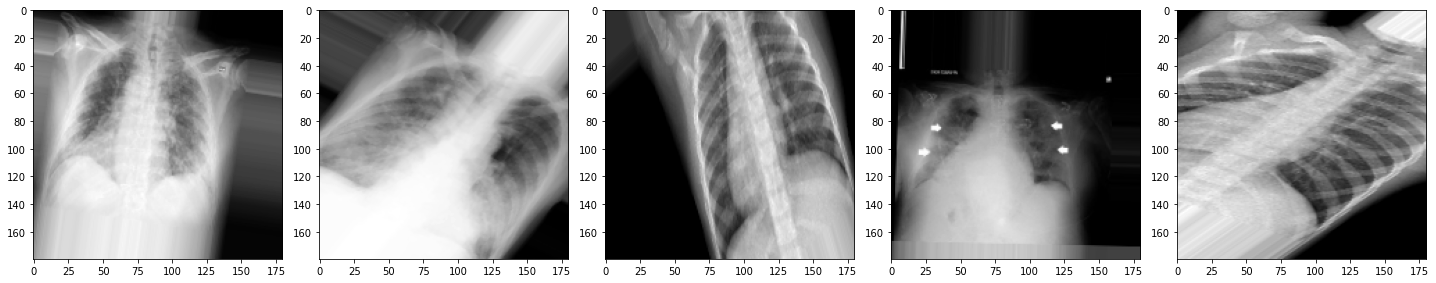

In [118]:
plotImages(sample_training_images[:5])  # Plot images 0-4

### Creating model

In [119]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Activation
import math

In [120]:
# # # Using batch normalization

# cnn = Sequential()

# cnn.add(Conv2D(12, (3, 3), activation='relu', input_shape=(IMG_SHAPE, IMG_SHAPE, 1)))
# # cnn.add(BatchNormalization(scale=False, center=True))
# # cnn.add(Activation('relu'))
# # cnn.add(MaxPooling2D(pool_size = (2, 2)))

# cnn.add(Conv2D(24, (6, 6), strides=2, use_bias=False))
# cnn.add(BatchNormalization(scale=False, center=True))
# cnn.add(Activation('relu'))
# # cnn.add(MaxPooling2D(pool_size = (2, 2)))

# cnn.add(Conv2D(32, (6, 6), strides=2, use_bias=False))
# cnn.add(BatchNormalization(scale=False, center=True))
# cnn.add(Activation('relu'))
# cnn.add(MaxPooling2D(pool_size = (2, 2)))

# # cnn.add(Conv2D(32, (6, 6), input_shape=(IMG_SHAPE, IMG_SHAPE, 1), strides=2, use_bias=False))
# # cnn.add(BatchNormalization(scale=False, center=True))
# # cnn.add(Activation('relu'))
# # cnn.add(MaxPooling2D(pool_size = (2, 2)))

# # cnn.add(Conv2D(64, (3, 3), input_shape=(IMG_SHAPE, IMG_SHAPE, 1), use_bias=False))
# # cnn.add(BatchNormalization(scale=False, center=True))
# # cnn.add(Activation('relu'))
# # cnn.add(MaxPooling2D(pool_size = (2, 2)))

# cnn.add(Flatten())

# cnn.add(Dense(units=200, use_bias=False))
# cnn.add(BatchNormalization(scale=False, center=True))
# cnn.add(Activation('relu'))
# cnn.add(Dropout(0.3))


# # cnn.add(Dense(units = 64, use_bias=False))
# # cnn.add(BatchNormalization(scale=False, center=True))
# # cnn.add(Activation('relu'))
# # cnn.add(Dropout(0.3))

# cnn.add(Dense(activation = 'softmax', units = 1))

In [140]:
cnn = Sequential()

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(IMG_SHAPE, IMG_SHAPE, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(IMG_SHAPE, IMG_SHAPE, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(IMG_SHAPE, IMG_SHAPE, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(IMG_SHAPE, IMG_SHAPE, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(IMG_SHAPE, IMG_SHAPE, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Flatten())

cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))

cnn.add(Dense(activation = 'sigmoid', units = 1))

In [141]:
cnn.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_77 (Conv2D)          (None, 178, 178, 32)      320       
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_78 (Conv2D)          (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 43, 43, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_79 (Conv2D)          (None, 41, 41, 32)        9248      
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 20, 20, 32)     

In [136]:
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=3)
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

In [142]:
cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [143]:
EPOCHS = 30
history = cnn.fit_generator(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen
    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/30
10/10 [==============================] - 5s 439ms/step - loss: 0.7150 - accuracy: 0.5000 - val_loss: 0.6925 - val_accuracy: 0.5000
Epoch 2/30
10/10 [==============================] - 4s 400ms/step - loss: 0.6922 - accuracy: 0.5361 - val_loss: 0.6890 - val_accuracy: 0.5000
Epoch 3/30
10/10 [==============================] - 4s 452ms/step - loss: 0.6907 - accuracy: 0.5876 - val_loss: 0.6783 - val_accuracy: 0.5000
Epoch 4/30
10/10 [==============================] - 4s 410ms/step - loss: 0.6846 - accuracy: 0.5309 - val_loss: 0.6569 - val_accuracy: 0.7727
Epoch 5/30
10/10 [==============================] - 4s 403ms/step - loss: 0.6446 - accuracy: 0.6804 - val_loss: 0.9743 - val_accuracy: 0.5000
Epoch 6/30
10/10 [==============================] - 4s 397ms/step - loss: 0.6787 - accuracy: 0.5979 - val_loss: 0.6294 - val_accuracy: 0.7727
Epoch 7/30
10/10 [==============================] - 4s 410ms/step - loss: 0.5935 - accuracy: 0.6959 - val_loss: 0.4290 - val_accuracy: 0.8636
Epoch 

### Visualizing CNN model

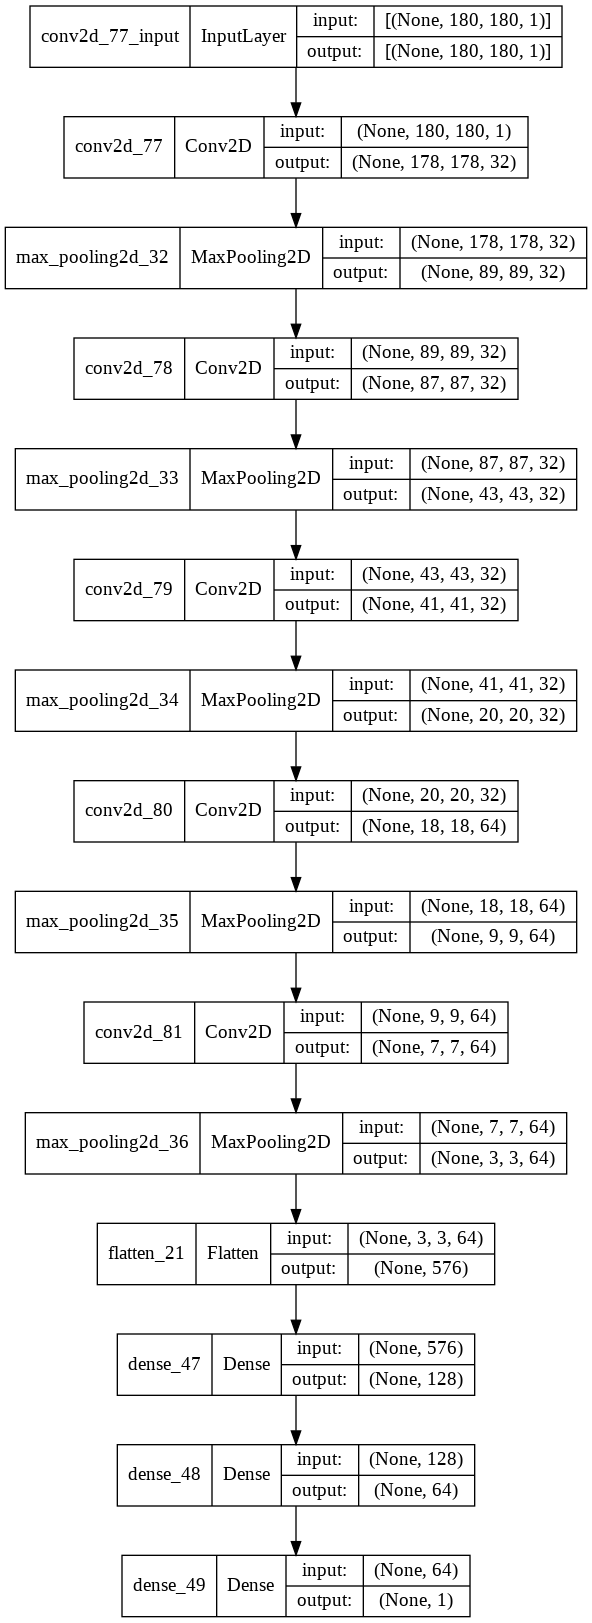

In [144]:
from tensorflow.keras.utils import plot_model
plot_model(cnn,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

### Prediction and Results

In [145]:
test_accu = cnn.evaluate(test_data_gen)
print('The testing accuracy is :',test_accu[1]*100, '%')

2/2 [==============================] - 1s 351ms/step - loss: 0.4656 - accuracy: 0.8125
The testing accuracy is : 81.25 %


In [146]:
preds = cnn.predict(test_data_gen,verbose=1)
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

2/2 [==============================] - 1s 350ms/step


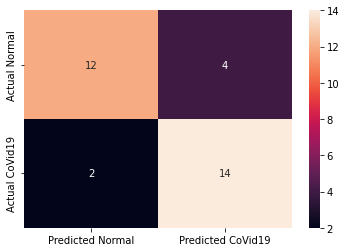

In [147]:
from sklearn.metrics import classification_report,confusion_matrix

cm = pd.DataFrame(data=confusion_matrix(test_data_gen.classes, predictions, labels=[0, 1]),index=["Actual Normal", "Actual CoVid19"],
columns=["Predicted Normal", "Predicted CoVid19"])

import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [148]:
print(classification_report(y_true=test_data_gen.classes,y_pred=predictions,target_names =['NORMAL','CoVid19']))

              precision    recall  f1-score   support

      NORMAL       0.86      0.75      0.80        16
     CoVid19       0.78      0.88      0.82        16

    accuracy                           0.81        32
   macro avg       0.82      0.81      0.81        32
weighted avg       0.82      0.81      0.81        32



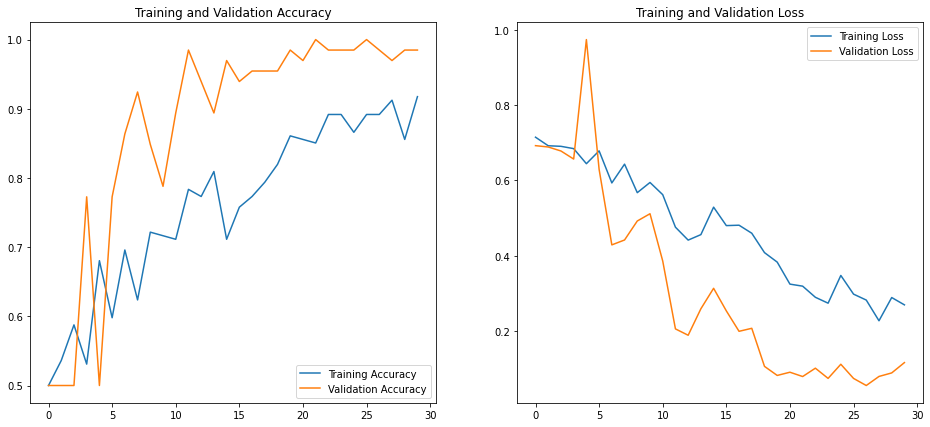

In [149]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()